<a href="https://colab.research.google.com/github/Hui606/DS_Biz_Group17/blob/master/DS_for_Biz_Proj_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read in the data

In [45]:
# import all libs
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score

import matplotlib.pyplot as plt

In [46]:
!git clone https://github.com/Hui606/DS_Biz_Group17.git
%cd DS_Biz_Group17

fatal: destination path 'DS_Biz_Group17' already exists and is not an empty directory.
/content/DS_Biz_Group17/DS_Biz_Group17


In [47]:

# TODO: need to find a better way to import later
# drive.mount('/content/drive')

In [48]:
# !ls "/content/drive/MyDrive/DS_for_Biz_Spring_2023/proj/dataset"
!ls "./"

crash_dataset.csv


In [49]:
# import the dataset
# If necessary change the path below so that it points to your file.
data_path = "crash_dataset.csv"

# Load the dataset
df = pd.read_csv(data_path)

<ipython-input-49-c80d17ce20cc>:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


## **Preprocessing**

In [50]:
# Convert CRASH TIME to one hour unit
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])
df['CRASH TIME'] = df['CRASH TIME'].dt.hour

# only keep the month
df['CRASH MONTH'] = pd.to_datetime(df['CRASH DATE']).dt.month

In [51]:
# define target variable CASUALTY_LEVEL = 1 if fatality >= 1, otherwise = 0
df['CASUALTY_LEVEL'] = (df['NUMBER OF PERSONS KILLED'] + df['NUMBER OF PEDESTRIANS KILLED'] + 
                        df['NUMBER OF CYCLIST KILLED'] + df['NUMBER OF MOTORIST KILLED']).apply(lambda x: 1 if x >= 1 else 0)

In [52]:
# case with fatality
print(np.count_nonzero(df['CASUALTY_LEVEL']))

2711


In [53]:
# select the features and target var
data = df[['CRASH MONTH', 'CRASH TIME', 'BOROUGH', 'ZIP CODE','NUMBER OF PERSONS INJURED', 
               'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
               'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
               'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 
               'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 
               'VEHICLE TYPE CODE 5', 'CASUALTY_LEVEL']]

# remove invalid rows
data = data.dropna(subset=['BOROUGH', 'NUMBER OF PERSONS INJURED','ZIP CODE'])

print(len(data.index))

# release RAM
del df

1364693


One-hot encoding CONTRIBUTING FACTOR VEHICLE

Also make sure "A,B" is same as "B,A"

In [54]:
# Extract the contributing factor columns
# data = data.head(6)
invalid_factor_placeholder = 'unspecified'
contributing_factor_cols = ['CONTRIBUTING FACTOR VEHICLE 1',
                            'CONTRIBUTING FACTOR VEHICLE 2',
                            'CONTRIBUTING FACTOR VEHICLE 3',
                            'CONTRIBUTING FACTOR VEHICLE 4',
                            'CONTRIBUTING FACTOR VEHICLE 5']

# replace all the NaN with placeholders
data[contributing_factor_cols] = data[contributing_factor_cols].replace(np.nan, invalid_factor_placeholder)
# print(data)
# delete rows where all the columns in contributing_factor_cols are 'Unspecified'
data = data[~(data[contributing_factor_cols] == invalid_factor_placeholder).all(axis=1)]

# lower the text to prevent case like "Illegal" and "illegal"
for c in contributing_factor_cols:
  data[c] = data[c].str.lower()

# One-hot encode the contributing factor columns
one_hot_df = pd.get_dummies(data[contributing_factor_cols], prefix='CF')
# print(one_hot_df)

#define function to merge columns with same names together
# def same_merge(x): return 1 if sum(x[x.notnull()].astype(float)) >= 1 else 0

#define new DataFrame that merges columns with same names together
one_hot_df = one_hot_df.groupby(level=0, axis=1).sum()

# loop through the specified columns and set them as binary
for col in one_hot_df:
  one_hot_df[col] = (one_hot_df[col] >= 1).astype(int)

# drop CONTRIBUTING FACTOR VEHICLE
data = data.drop(contributing_factor_cols, axis=1)
data = pd.concat([data, one_hot_df], axis=1)

# remove the col 'CF_Unspecified'
data = data.drop(f'CF_{invalid_factor_placeholder}', axis=1)

# print(data)

print(len(data.index))

1359988


Now we do the same thing to VEHICLE TYPE CODE.

But one more operation is to keep only the top 'limit' codes as there are over 1000 codes which are too many for one-hot encoding.

In [55]:

# data = data.head(6)

# Extract the contributing factor columns
invalid_type_code_placeholder = 'unspecified'
vehicle_type_code_cols = ['VEHICLE TYPE CODE 1',
                            'VEHICLE TYPE CODE 2',
                            'VEHICLE TYPE CODE 3',
                            'VEHICLE TYPE CODE 4',
                            'VEHICLE TYPE CODE 5']

# get the top 'limit' values in the column ranked by frequency 
# and remove all others. Doing this due to RAM limit
limit = 50
for c in vehicle_type_code_cols:
  # get the top 'limit' values in the column ranked by frequency
  top_freq_values = data[c].value_counts().nlargest(limit).index.tolist()

  # sort the top values by frequency and then by alphabetical order
  top_freq_values = sorted(top_freq_values, key=lambda x: (-data[c].value_counts()[x], x))

  # replace all values not in the top 50 with NaN
  data.loc[~data[c].isin(top_freq_values), c] = np.nan

# print(data[vehicle_type_code_cols])

In [56]:


# replace all the NaN with placeholders
data[vehicle_type_code_cols] = data[vehicle_type_code_cols].replace(np.nan, invalid_type_code_placeholder)
# print(data)
# delete rows where all the columns in contributing_factor_cols are 'Unspecified'
data = data[~(data[vehicle_type_code_cols] == invalid_type_code_placeholder).all(axis=1)]

# lower the text to prevent case like "Illegal" and "illegal"
for c in vehicle_type_code_cols:
  data[c] = data[c].str.lower()

# One-hot encode the contributing factor columns
one_hot_df = pd.get_dummies(data[vehicle_type_code_cols], prefix='VTC')
# print(one_hot_df)

#define new DataFrame that merges columns with same names together
one_hot_df = one_hot_df.groupby(level=0, axis=1).sum()

# loop through the specified columns and set them as binary
for col in one_hot_df:
  one_hot_df[col] = (one_hot_df[col] >= 1).astype(int)

# drop CONTRIBUTING FACTOR VEHICLE
data = data.drop(vehicle_type_code_cols, axis=1)
data = pd.concat([data, one_hot_df], axis=1)

# remove the col 'CF_Unspecified'
data = data.drop(f'VTC_{invalid_factor_placeholder}', axis=1)

# print(data)

print(len(data.columns))

124


In [57]:
print(data.columns)

Index(['CRASH MONTH', 'CRASH TIME', 'BOROUGH', 'ZIP CODE',
       'NUMBER OF PERSONS INJURED', 'CASUALTY_LEVEL', 'CF_1', 'CF_80',
       'CF_accelerator defective', 'CF_aggressive driving/road rage',
       ...
       'VTC_tow truck / wrecker', 'VTC_tractor tr', 'VTC_tractor truck diesel',
       'VTC_tractor truck gasoline', 'VTC_trailer', 'VTC_trailor', 'VTC_unkno',
       'VTC_unknown', 'VTC_van', 'VTC_van ford'],
      dtype='object', length=124)


Next we one-hot encode MONTH, TIME(hour unit), ZIP CODE, BOROUGH

In [58]:
print(len(data.index))

1352194


In [59]:
one_hot = pd.get_dummies(data['CRASH MONTH'], prefix='MONTH')
data = data.join(one_hot)

one_hot = pd.get_dummies(data['CRASH TIME'], prefix='TIME')
data = data.join(one_hot)

In [60]:
one_hot = pd.get_dummies(data['ZIP CODE'], prefix='ZIP_CODE')

data = pd.concat([data, one_hot], axis=1)

In [61]:
one_hot = pd.get_dummies(data['BOROUGH'], prefix='BOROUGH')

data = pd.concat([data, one_hot], axis=1)

In [62]:
# get rid of uncoded cols
data = data.drop(['CRASH MONTH',
'CRASH TIME',
'BOROUGH',
'ZIP CODE'], axis=1)

In [63]:
count = ((data['CASUALTY_LEVEL'] == 1)).sum() # how many cases have death
print(count)

1597


Save the pre-processed dataset as CSV for later reuse

In [64]:
# data.to_csv('crash_training_data.csv')

## **Training**
We can start sampling by undersampling as we have one 1% case with death

In [65]:
# Undersample majority class
from sklearn.utils import resample

# Separate majority and minority classes
majority = data[data['CASUALTY_LEVEL']==0]
minority = data[data['CASUALTY_LEVEL']==1]

# Undersample majority class
undersampled_majority = resample(majority, replace=False, n_samples=len(minority), random_state=42)

# Combine minority class with undersampled majority class
training = pd.concat([undersampled_majority, minority])

Normalizing

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# select numerical columns
numerical_cols = training.columns

# normalize numerical columns
scaler = MinMaxScaler()
training[numerical_cols] = scaler.fit_transform(training[numerical_cols])

Split the data to 4 parts

In [67]:
# Split data into features and target variable
X = training.drop(['CASUALTY_LEVEL'], axis=1)
y = training['CASUALTY_LEVEL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Use ROC to find the best model

In [68]:
# Model 1: Decision tree classifier
dt_scores = []
for min_samples_leaf in range(1, 21, 5):
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=10, scoring='roc_auc')
    dt_scores.append((min_samples_leaf, scores.mean()))

best_dt = max(dt_scores, key=lambda x: x[1])
print("Best Decision Tree Classifier: min_samples_leaf={}, ROC AUC={:.4f}".format(best_dt[0], best_dt[1]))

# Model 2: Logistic regression
lr_scores = []
for C in np.logspace(-4, 4, 8):
    lr = LogisticRegression(C=C, random_state=42, max_iter = 5000)
    scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='roc_auc')
    lr_scores.append((C, scores.mean()))

best_lr = max(lr_scores, key=lambda x: x[1])
print("Best Logistic Regression: C={}, ROC AUC={:.4f}".format(best_lr[0], best_lr[1]))

# # Model 3: Random forest classifier
rf_scores = []
for n_estimators in range(100, 300, 100):
    for max_depth in range(5, 21, 5):
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='roc_auc')
        rf_scores.append(((n_estimators, max_depth), scores.mean()))

best_rf = max(rf_scores, key=lambda x: x[1])
print("Best Random Forest Classifier: n_estimators={}, max_depth={}, ROC AUC={:.4f}".format(best_rf[0][0], best_rf[0][1], best_rf[1]))

models = {'Decision tree classifier': best_dt, 'Logistic regression': best_lr, 'Random forest classifier': best_rf}
best_model = max(models.items(), key=lambda x: x[1][1])

print(f'The best model is {best_model[0]}')

Best Decision Tree Classifier: min_samples_leaf=16, ROC AUC=0.7703
Best Logistic Regression: C=0.2682695795279725, ROC AUC=0.8043
Best Random Forest Classifier: n_estimators=200, max_depth=20, ROC AUC=0.8189
The best model is Random forest classifier


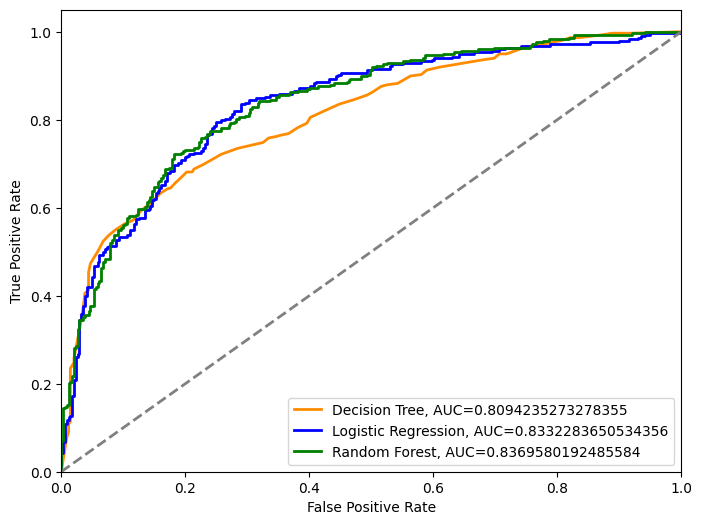

In [69]:
# Fit the best models found in the previous question
dtc = DecisionTreeClassifier(min_samples_leaf=models['Decision tree classifier'][0])
dtc.fit(X_train, y_train)

lr = LogisticRegression(C=models['Logistic regression'][0], max_iter = 5000)
lr.fit(X_train, y_train)

rfc = RandomForestClassifier(n_estimators=models['Random forest classifier'][0][0], max_depth=models['Random forest classifier'][0][1])
rfc.fit(X_train, y_train)

# Predict probabilities for each model
y_pred_dtc = dtc.predict_proba(X_test)[:, 1]
y_pred_lr = lr.predict_proba(X_test)[:, 1]
y_pred_rfc = rfc.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for each model
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, y_pred_dtc)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_rfc)

roc_auc_dtc = auc(fpr_dtc, tpr_dtc)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtc, tpr_dtc, color='darkorange', lw=2, label=f'Decision Tree, AUC={roc_auc_dtc}')
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression, AUC={roc_auc_lr}')
plt.plot(fpr_rfc, tpr_rfc, color='green', lw=2, label=f'Random Forest, AUC={roc_auc_rfc}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [70]:
y_pred_lr_binary = y_pred_lr > 0.5  # convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred_lr_binary)
print("Accuracy:", accuracy)

y_pred_rfc_binary = y_pred_rfc > 0.5  # convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred_rfc_binary)
print("Accuracy:", accuracy)

# precision = precision_score(y_test, y_pred_lr_binary)
# print("Precision:", precision)

Accuracy: 0.7636932707355243
Accuracy: 0.7652582159624414
